# Searching PDFs with Python, Transformers and Machine Learning

Have you ever been searching through a stack of files and just can't find the right keywords to get what you're looking for? Staring at a screen and wracking your brain at 3am for the right word ain't fun, take it from me.

How about trying to search through a stack of PDFs? That gets even harder since all that nice plain text is wrapped up in [a gnarly format](https://forum.quartertothree.com/t/is-pdf-an-evil-format/58598). Good luck grepping those!

In this notebook we're going to kill those two birds with one stone.

We'll harness the power of AI to find things *similar* to the search query you input, and we'll show you how to deploy that search engine in real life for anyone to use.

We're going to do this with open-source tools from the Jina ecosystem.

## Taking our time to learn

We're going to take our time in this notebook, so we can understand how each part of the indexing/search pipeline (aka Flow) does its thing and check on our Documents every step of the way to see what the Flow did to them. This will give us a proper understanding of what's happening, instead of doing lots of hand-waving and making it look like dark magic.

We'll then see how this process would be performed more quickly by building the Flow "all-in-one", as you would often do when building in production.

## Why Jina and [neural search](https://docs.jina.ai/get-started/neural-search/)? What's wrong with good old symbolic search?

### Semantics semantics semantics!

Instead of just pattern-matching, our search engine will *meaning*-match. So if we were to search `matrix`, our top results would be related to matrices, but we'd also get results for vectors, tensors, and other similar concepts. This is because we're using deep neural nets (DNNs) to arrange words in a vector space and compare their embeddings, and similar words have similar [embeddings](https://docarray.jina.ai/fundamentals/document/embedding/).

### Less code to write

We can also reduce the amount of code we need to write using Jina Hub. Instead of manually integrating [Transformers](https://hub.jina.ai/executor/u9pqs8eb) with our search engine, we can simply use a couple of lines of code to download it from [Jina Hub](https://hub.jina.ai), run it in Docker, or run it in a [sandbox](https://docs.jina.ai/how-to/sandbox/) on the cloud. And if we wanted to swap it out for something like [spaCy](https://hub.jina.ai/executor/u7h7cuh2)? Again, just a matter of changing a couple of lines of code.

### Deployment made easy

Also, tools like Jina take a lot of hassle out of the orchestration and scaling. We can easily add [sharding, replicas](https://docs.jina.ai/how-to/scale-out/?highlight=sharding), [Kubernetes integration](https://docs.jina.ai/how-to/kubernetes/), and so on. 

## Meet our ingredients

### **[DocArray](https://docarray.jina.ai/)**

DocArray is a library for nested, unstructured data in transit, including text, image, audio, video, 3D mesh, etc. It allows deep-learning engineers to efficiently process, embed, search, recommend, store, and transfer the multi-modal data with a Pythonic API. ([star the repo]())

###**[Jina](https://docs.jina.ai)**
 
 Jina is a framework that empowers anyone to build cross-modal and multi-modal[*] applications on the cloud. It uplifts a PoC into a production-ready service. Jina handles the infrastructure complexity, making advanced solution engineering and cloud-native technologies accessible to every developer. ([star the repo]())

### **[Jina Hub](https://hub.jina.ai)**

Download pre-built building blocks for neural search.

## Without further ado...

Let's start by downloading our data:

## Downloading our data

We're going to use simple text PDFs, with text taken from two Wikipedia pages ([Rabbit](https://en.wikipedia.org/wiki/Rabbit) and [Tiger](https://de.wikipedia.org/wiki/Tiger)). 

Of course, this is just a toy dataset. PDFs can differ in many ways, and depending on your use case you may need to process them very differently (e.g. OCR, image processing). Since ours are simple plain text, these steps will apply to most PDF search engines you may wish to build.

In [ ]:
# Get data
!mkdir data
!wget -q --directory-prefix ./data https://github.com/jina-ai/workshops/raw/main/pdf_search/data/rabbit.pdf
!wget -q --directory-prefix ./data https://github.com/jina-ai/workshops/raw/main/pdf_search/data/tiger.pdf

## Installing DocArray

DocArray is a library for nested, unstructured data in transit, including text, image, audio, video, 3D mesh, etc. It allows deep-learning engineers to efficiently process, embed, search, recommend, store, and transfer the multi-modal data with a Pythonic API.

We'll use Jina to build our search pipeline (a.k.a [Flow](https://docs.jina.ai/fundamentals/flow/)) in a while. Everything that goes in or out of Jina has to be in the form of a [Document](https://docarray.jina.ai/fundamentals/document/) or [DocumentArray](https://docarray.jina.ai/fundamentals/documentarray/), provided by the DocArray package.

In [ ]:
!pip install -q docarray

In [ ]:
from docarray import DocumentArray

## Loading our PDF files

DocArray includes a handy shortcut to [load every file matching a glob](https://docarray.jina.ai/fundamentals/documentarray/construct/#construct-from-local-files). We can then use the `.summary()` method to see an overview of the output.

As we go through the process in this notebook we'll regularly check our summary to see what's happening with our Documents as they move through the Flow.

In [ ]:
docs = DocumentArray.from_files("data/*.pdf", recursive=True)
docs.summary()

### Loading to blobs

Right now the Documents contain only the URIs to the PDF files (as well as some other very basic data), but not the PDF content itself. We'll [load those URIs into blobs](https://docarray.jina.ai/fundamentals/document/fluent-interface/#blobdata):

In [ ]:
for doc in docs:
  doc.load_uri_to_blob()

In [ ]:
docs.summary()

## Installing Jina

[Jina]() is a framework that empowers anyone to build cross-modal and multi-modalapplications on the cloud. It uplifts a PoC into a production-ready service. Jina handles the infrastructure complexity, making advanced solution engineering and cloud-native technologies accessible to every developer.

In [ ]:
!pip install -q jina # Let's silence some of the output with -q so we don't fill our notebook with junk

## Creating an indexing Flow

We'll use Jina to generate our indexing and searching [Flows](https://docs.jina.ai/fundamentals/flow/). Our Documents will pass through these when we're indexing or searching. 


A Flow is built out of [Executors](https://docs.jina.ai/fundamentals/executor/), each of which perform a single processing task on each Document. We'll use [Jina Hub]() to provide pre-made Executors, meaning we don't have to write so much code.

We'll build our Flow step by step through this notebook to get a clear idea of what's happening.

Let's start with an empty Flow:

In [ ]:
from jina import Flow

flow = Flow()

And let's plot our Flow so we can see what we've got:

In [ ]:
flow.plot()

As you can see, right now it's just a gateway in and a gateway out. In the next few steps we'll build up the rest of our Flow.

### Extract PDF data

If we're going to search through files, we need to get them into a format that our encoder can understand. In our case, that's plain text.

We'll use [PDFSegmenter](https://hub.jina.ai/executor/x9w7lcwg) to extract that from our PDF Documents and store the sections of text as [chunks](https://docarray.jina.ai/fundamentals/document/nested/).

Let's pull it from Jina Hub, so we can save ourselves the hassle of manually integrating it into our Flow. This will be a common pattern throughout this tutorial.

**Note:** PDFSegmenter also extracts images from PDFs. Since our PDFs are text-only that's not important for this tutorial.

In [ ]:
flow = flow.add(
    uses="jinahub://PDFSegmenter",
    install_requirements=True,
    name="segmenter"
    )

In [ ]:
flow.plot()

Now we need to run our Flow. Since we're building the indexing pipeline right now, let's run it with `flow.index()`:

In [ ]:
with flow:
  docs = flow.index(docs, show_progress=True)

Now that our Documents have been processed by the Flow, let's see what's changed:

In [ ]:
docs.summary()

As you can see, each Document now has "chunks", consisting of the text extracted from each PDF. We can look at the chunks in more detail:

In [ ]:
docs["@c"]

The text in each chunk is pretty long:

In [ ]:
docs["@c"].texts

### Sentencize the chunks

Those chunks of text are still pretty unwieldy. To get decent results we'll need to chop them up some more by cutting them into sentences, and store each sentence as a subchunk of the original chunk.

We'll use [SpacySentencizer](https://hub.jina.ai/executor/197kj4fv) to do that. You'll see that we're traversing through chunks of Documents rather than the top-level Documents themselves. That's because PDFSegmenter stored the text it extracted as chunks. We do this with `{"traversal_paths": "@c"}`.

In [ ]:
flow = flow.add(
    uses="jinahub://SpacySentencizer",
    uses_with={"traversal_paths": "@c"},
    install_requirements=True,
    name="sentencizer"
    )

In [ ]:
flow.plot()

---

**⚙️ Tinker time**

Why not use the vanilla [Sentencizer](https://hub.jina.ai/executor/c6focg47)? Because it cuts sentences based on punctuation (like `.`) rather than natural language processing.

That means a sentence like "J.R.R. Tolkien turned to p. 3 of the book" would be considered as five sentences by vanilla Sentencizer but only one by SpacySentencizer!

---

Once again, let's index and examine what we've got:

In [ ]:
with flow:
  docs = flow.index(docs)

In [ ]:
docs.summary()

We can see the structure of our first Document here, showing 

* The top-level Document
* Chunks (extracted by PDFSegmenter)
* Chunks-of-chunks (the sentences extracted by SpacySentencizer):

In [ ]:
docs[0]

Now we can burrow down to the chunks-of-chunks level. For each level of chunk you want to go down, you can add another `c` to `["@c"]`. So:

- Top-level Document
  - `["@c"]` - chunks
    - `["@cc"]` - chunks of chunks

In [ ]:
docs["@cc"]

In [ ]:
docs["@cc"].texts

### Encode the text

To be able to do nearest-neighbor search, we need to be able to compare sentences' meanings with each other. This is where our encoder comes in. It generates [vector embeddings](https://docarray.jina.ai/fundamentals/document/embedding/) based on the semantic meaning of each sentence.

As you can see, we're specifying the traversal path to work on chunks-of-chunks (i.e. sentences) rather than higher-level chunks (i.e. big blocks of text).

In [ ]:
flow = flow.add(
    uses="jinahub://TransformerTorchEncoder",
    uses_with={"traversal_paths": "@cc"},
    install_requirements=True,
    name="encoder",
    )

In [ ]:
flow.plot()

---
**⚙️ Tinker time**

In our example we're using [TransformerTorchEncoder](https://hub.jina.ai/executor/u9pqs8eb) with the default model (`sentence-transformers/all-mpnet-base-v2`). You can specify your own model as follows:

```python
flow = flow.add(
    uses="jinahub://TransformerTorchEncoder",
    uses_with={
      "traversal_paths": "@cc",
      "pretrained_model_name_or_path": "hfl/chinese-macbert-base" # Chinese language model
      },
    install_requirements=True,
    name="encoder",
    )
```

To go even further, you could swap out Transformers for another Executor, like [spaCy](https://hub.jina.ai/executor/u7h7cuh2):

```python
flow = flow.add(
    uses="jinahub://SpacyTextEncoder",
    uses_with={
      "traversal_paths": "@cc",
      "model_name": "en_core_web_md"
      },
    install_requirements=True,
    name="encoder",
    )
```

---

In [ ]:
with flow:
  docs = flow.index(docs, show_progress=True)

After running our Flow this time, we see each Sentence (at `["@cc"]`) has an `embedding` attribute, storing its vector embedding. The shape of this embedding varies depending on the Executor and model we use to encode it. Here's the embedding representation of the first sentence (i.e. sub-chunk) of the first chunk of our first PDF file:

In [ ]:
docs[0].chunks[0].chunks[0]

### Index and store Documents

Now it's time to store all that data (vector embeddings + other metadata) on disk. We'll do this with the [SimpleIndexer](https://hub.jina.ai/executor/zb38xlt4) Executor. It will store everything in a SQLite database on disk.

In [ ]:
flow = flow.add(
    uses="jinahub://SimpleIndexer",
    uses_with={"traversal_right": "@cc"},  # search through sub-chunks
    install_requirements=True,
    name="indexer"
    )

In [ ]:
flow.plot()

In [ ]:
with flow:
  docs = flow.index(docs, show_progress=True)

If you click the folder icon in the Colab sidebar you should now see the "workspace" folder where everything is stored:
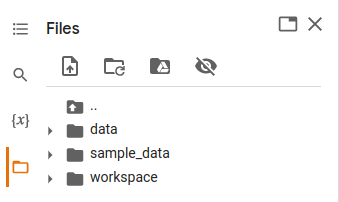

## Building a more "production-ready" Flow

Our Flow was built in a very scattered way since we stepped through everything step-by-step. In the real world you would typically create a Flow "all-in-one" like this:

In [ ]:
flow = (
    Flow()
    .add(
        uses="jinahub://PDFSegmenter",
        install_requirements=True,
        name="segmenter"
    )
    .add(
        uses="jinahub://SpacySentencizer",
        uses_with={"traversal_paths": "@c"},
        install_requirements=True,
        name="sentencizer",
    )
    .add(
        uses="jinahub://TransformerTorchEncoder",
        uses_with={"traversal_paths": "@cc"},
        install_requirements=True,
        name="encoder"
    )
    .add(
        uses="jinahub://SimpleIndexer",
        uses_with={"traversal_right": "@cc"},
        install_requirements=True,
        name="indexer"
    )
)

In [ ]:
flow.plot()

---
**⚙️ Tinker time**

You can also build a Flow in YAML and import it using:

```python
flow = Flow().

---

## Indexing our Documents

Now it's time to run the Flow.

First we'll remove any old index data that may be lying around and start with our original DocumentArray to ensure nothing carried over:

In [ ]:
!rm -rf workspace
docs = DocumentArray.from_files("data/*.pdf", recursive=True)

And now we'll run the Flow:

In [ ]:
with flow:
  docs = flow.index(docs, show_progress=True)

## Creating a search Flow

Now that we've got our indexing Flow out of the way, let's build our search Flow.

When a user searches, they'll submit just a simple text string, not a PDF. Therefore we can use a much simpler Flow since we don't need to worry about extracting and sentencizing the input query:

In [ ]:
search_flow = (
    Flow()
    .add(
        uses="jinahub://TransformerTorchEncoder", 
         name="encoder"
    )
    .add(
        uses="jinahub://SimpleIndexer",
        uses_with={"traversal_right": "@cc"},
        name="indexer"
    )
)

In [ ]:
search_flow.plot()

If we're going to search our index, we'll need a search term, which we'll specify here.

As you might have noticed, everything going into (and coming out of) Jina is a Document or DocumentArray. That means we'll need to wrap our search term into a Document as well:

In [ ]:
search_term = "where does a snow leopard live?"

from docarray import Document

query_doc = Document(text=search_term)

In [ ]:
with search_flow:
  results = search_flow.search(query_doc, show_progress=True, return_results=True)

Let's look at those results and see the score assigned to each match. Since we're using cosine similarity, a lower score means a better match:

In [ ]:
for match in results[0].matches:
  print(match.text)
  print(match.scores["cosine"].value)
  print("---")

## Putting it into production

Colab notebooks have a number of restrictions that make real-world stuff quite difficult. If we were building this outside of a notebook, we could:

* Set up a [RESTful or gRPC gateway](https://docs.jina.ai/fundamentals/gateway/) and keep the Flow open to requests using `flow.block()`
* Use [sharding and replicas](https://docs.jina.ai/how-to/scale-out/) to improve performance and reliability.
* [Monitor our Flow with Grafana](https://docs.jina.ai/fundamentals/flow/monitoring-flow/)
* Better yet, host our Flow on [JCloud](https://docs.jina.ai/fundamentals/jcloud/), so we don't have to use any of our own compute for encoding, indexing, hosting, etc (encoding is especially hungry on the hardware)
* Finetune our results using [Finetuner](https://finetuner.jina.ai) to provide better matches
* Use a more specialized model (rather than just general purpose)

## Learn more

Want to dig more into the Jina ecosystem? Here are some resources:

- [Developer portal](https://learn.jina.ai) - tutorials, courses, videos on using Jina
- [Fashion search notebook](https://colab.research.google.com/github/alexcg1/neural-search-notebooks/blob/main/fashion-search/1_build_basic_search/basic_search.ipynb) - build an image-to-image fashion search engine
- [DALL-E Flow](https://colab.research.google.com/github/jina-ai/dalle-flow/blob/main/client.ipynb#scrollTo=NeWDy9viOCAP)/[Disco Art](https://colab.research.google.com/github/jina-ai/discoart/blob/main/discoart.ipynb#scrollTo=47428f37) - create AI-generated art in your browser